<a href="https://colab.research.google.com/github/simongiando/deep-learning/blob/main/practice/basic_DL_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TensorFlow and Kerasfor geospatial computer vision**


Objectives:
1. Load prebuilt geospatial datasets. We’ll show how to do this firstly with [TensorFlow Datasets](https://www.tensorflow.org/datasets) and secondly with [Radiant Earth MLHub](https://mlhub.earth/).
2. Build a neural network machine learning model that classifies images.

3. Train this neural network.

4. Evaluate the accuracy of the model.

In [1]:
# Check Python Version
!python3 --version

Python 3.10.12


In [6]:
# install required libraries
# !pip install -q rasterio==1.3.8
# !pip install -q geopandas==0.13.2
# !pip install -q tensorflow-data-validation==1.3.0 # Only works with Python versions 3.9 or earlier
#!export TFX_DEPENDENCY_SELECTOR=NIGHTLY
!pip install -q --extra-index-url https://pypi-nightly.tensorflow.org/simple tensorflow-data-validation
!pip install -q radiant_mlhub # for dataset access, see: https://mlhub.earth/

ERROR: Could not find a version that satisfies the requirement tensorflow-data-validation==1.3.0 (from versions: 1.14.0)
ERROR: No matching distribution found for tensorflow-data-validation==1.3.0


In [7]:
import os, glob, functools, fnmatch, io, shutil, tarfile, json
from zipfile import ZipFile
from itertools import product
from pathlib import Path
import urllib.request
from radiant_mlhub import Dataset, client, get_session, Collection
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from google.colab import drive
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
#import tensorflow_data_validation
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [8]:
import tensorflow as tf
print("TensorFlow version", tf.__version__)

TensorFlow version 2.15.0


In [9]:
# set your folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    processed_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-2-processed-outputs/'
    user_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-2-user_outputs_dir'
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
    print('Running on Colab')
else:
    processed_outputs_dir = os.path.abspath("./data/tf-eo-devseed-2-processed-outputs")
    user_outputs_dir = os.path.abspath('./tf-eo-devseed-2-user_outputs_dir')
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
        os.makedirs(processed_outputs_dir)
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(processed_outputs_dir)}')

Mounted at /content/gdrive
Running on Colab


In [10]:
# Move to your user directory in order to write data
%cd $user_outputs_dir

/content/gdrive/My Drive/tf-eo-devseed-2-user_outputs_dir


# Use a dataset from TensorFlow Datasets

[TensorFlow Datasets](https://www.tensorflow.org/datasets), accessible via the importable API `tfds`, is convenient compared to working with raw geotiffs from file, as the associated pre-packaged datasets are accompanied by TensorFlow’s ecosystem of methods for attribution and exploration. The standardized packaging of these datasets also makes it easier to parallelize pre-processing operations which in turn makes it easier to create simple and efficient data pipelines.

We will use the Eurosat dataset, which contains labeled Sentinel-2 image patches classified into 10 land cover types. More details here: https://www.tensorflow.org/datasets/catalog/eurosat

The classes in this dataset are: `['Industrial', 'Pasture', 'River', 'Forest', 'AnnualCrop', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'SeaLake']`

The dataset will be partitioned into training, validation and testing splits with a `70:20:10` ratio, respectively.

In [12]:
def convert_datasets(dataset, image_arrays_list,label_integers_list):
  """
  Prepare a dict-style dataset in the format Keras expects, (features, labels).
  """
  for features in dataset.take(len(dataset)):
    image, label = features["image"], features["label"]
    image_arrays_list.append(image)
    label_integers_list.append(label)
  x_dataset, y_dataset = np.array(image_arrays_list), np.array(label_integers_list)
  return x_dataset, y_dataset

In [14]:
# Construct tf.data.Dataset(s)
all_dataset, ds_info = tfds.load(name="eurosat/rgb", split=tfds.Split.TRAIN, with_info=True)

# Shuffle the data before we partition it to make sure we don't have any unwarranted bias
all_dataset = all_dataset.shuffle(1024)

# Extract 30% of samples from the dataset for non-training
val_dataset = all_dataset.take(int(len(all_dataset)*0.3))

# Ensure 30% is excluded when setting training dataset
train_dataset = all_dataset.skip(int(len(all_dataset)*0.3))

# Take 30% of the non-training samples to use for testing, this makes up approaximately 10% of the original dataset
test_dataset = val_dataset.take(int(len(val_dataset)*0.3))

# Ensure the validation data skip that test reserve
val_dataset = val_dataset.skip(int(len(val_dataset)*0.3))

print("Number of samples in each split (train, val, test): ", len(train_dataset), len(val_dataset), len(test_dataset))

train_image_arrays = []
train_label_integers = []
val_image_arrays = []
val_label_integers = []
test_image_arrays = []
test_label_integers = []

x_train, y_train = convert_datasets(train_dataset, train_image_arrays, train_label_integers)
x_val, y_val = convert_datasets(val_dataset, val_image_arrays, val_label_integers)
x_test, y_test = convert_datasets(test_dataset, test_image_arrays, test_label_integers)

Number of samples in each split (train, val, test):  18900 5670 2430


In [16]:
# Check for all classes in each split
# set(train_label_integers), set(test_label_integers)

In [15]:
# Dataset specific parameters to be used in the model structure
INPUT_SHAPE =(64, 64, 3)
NUM_CLASSES = 10

Let’s visualize examples of the classes in the dataset

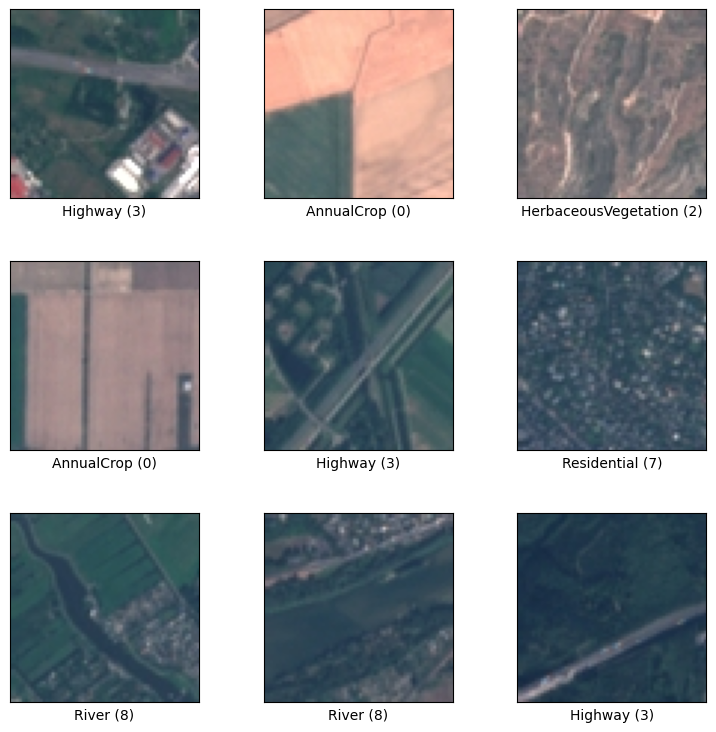

In [17]:
fig = tfds.show_examples(all_dataset, ds_info)

In [19]:
# tfds.show_statistics(ds_info)

In [20]:
# Build a very basic machine learning model

We’ll use the tf.keras.Sequential model structure:

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES)
])

The `Sequential` structure is designed to stack layers where each layer has an input `a tensor` and an output tensor. Layers themselves are simply functions performing matrix calculations. They may contain trainable variables and are reusable.

It is most common for TensorFlow models to be composed of layers. This sequential model is composed of the `Flatten`, `Dense`, and `Dropout` layers.

For each data sample provided the model, the corresponding output is a vector of `logits` or `log-odds` scores, for each class.

In [41]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 1891.2666  ,  -438.74915 ,  -468.9233  ,  1440.8485  ,
          347.03345 , -1568.4841  ,   607.3741  ,  1142.2506  ,
        -2648.7686  ,   100.202156]], dtype=float32)

In [42]:
tf.nn.softmax(predictions).numpy()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [43]:
tf.nn.softmax(predictions).numpy().min(), tf.nn.softmax(predictions).numpy().max()

(0.0, 1.0)

The next step is to specify a loss function for training. We will be using losses.SparseCategoricalCrossentropy as it is a commonly used loss function for multi-class data:

In [44]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The input to the loss function is a vector of ground truth values and a vector of logits. The returned output is a scalar loss for each data sample. Loss values close to zero are good, as they imply proximity to the correct class.

The untrained model will produce probabilities close to random for each class.

Before the model can be trained, it needs to be configured and compiled, using Keras `Model.compile`. In this step, we establish the `optimizer` class (which in this case will be `adam`), the `loss` to the loss_fn function defined earlier, and a metric that will be used evaluate the model at each iteration (herein we will use `accuracy`).

In [45]:
# learning rate
lr = 0.001
# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [46]:
model.compile (optimizer=optimizer,
               loss=loss_fn,
               metrics=['accuracy'])

In [47]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1572992   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1574282 (6.01 MB)
Trainable params: 1574282 (6.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


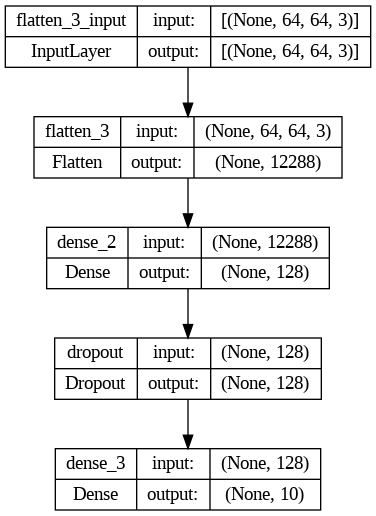

In [48]:
# Visualize the model
plot_model (model, show_shapes=True)

# **Train and evaluate your model**

No we will train the model using the `Model.fit` Keras method. During the following iterations, the model parameters will adjust and we will hope to see the loss.

In [49]:
# We will save the model fit history as an object to subsequently get attributes from (e.g. loss curves).
# This is an optional measure.
history = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs=10)

Epoch 1/10
591/591 [==============================] - 17s 28ms/step - loss: 21.3947 - accuracy: 0.1051 - val_loss: 2.2958 - val_accuracy: 0.1159
Epoch 2/10
591/591 [==============================] - 15s 25ms/step - loss: 2.2972 - accuracy: 0.1104 - val_loss: 2.2932 - val_accuracy: 0.1120
Epoch 3/10
591/591 [==============================] - 18s 30ms/step - loss: 2.2967 - accuracy: 0.1111 - val_loss: 2.2926 - val_accuracy: 0.1086
Epoch 4/10
591/591 [==============================] - 18s 31ms/step - loss: 2.2966 - accuracy: 0.1079 - val_loss: 2.2925 - val_accuracy: 0.1086
Epoch 5/10
591/591 [==============================] - 14s 23ms/step - loss: 2.2966 - accuracy: 0.1107 - val_loss: 2.2923 - val_accuracy: 0.1120
Epoch 6/10
591/591 [==============================] - 15s 25ms/step - loss: 2.2966 - accuracy: 0.1072 - val_loss: 2.2923 - val_accuracy: 0.1086
Epoch 7/10
591/591 [==============================] - 16s 27ms/step - loss: 2.2966 - accuracy: 0.1097 - val_loss: 2.2924 - val_accuracy

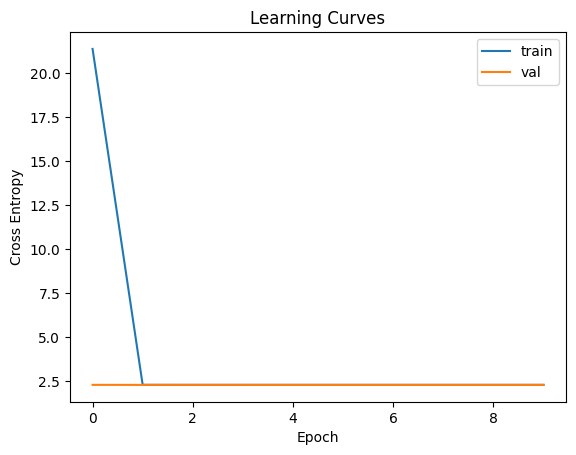

In [51]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

To evaluate the mode, we will use the `Model.evaluate` Keras method. The performance is evaluated on a [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [52]:
model.evaluate(x_test, y_test, verbose=2)

76/76 - 1s - loss: 2.2906 - accuracy: 0.1111 - 553ms/epoch - 7ms/step


[2.290616750717163, 0.1111111119389534]

We can return probabilities for the predictions by attaching a softmax to the trained model.

In [55]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

Now, let’s take the first test image, plot it and get the predicted class-wise probabilities.

In [58]:
def display (display_list):
  plt.figure(figsize=(5,5))

  title = ['Test Image']

  for i in range (len(display_list)):
    plt.subplot(1, len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

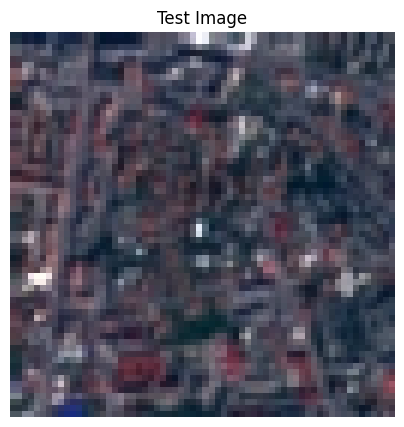

In [69]:
# Display sample test image
display ([x_test[2]])

In [70]:
probabilities = probability_model(x_test[[0]])
probabilities

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.1088573 , 0.10909334, 0.1108905 , 0.09232828, 0.09346946,
        0.07784887, 0.09315344, 0.11120035, 0.09324447, 0.10991401]],
      dtype=float32)>

In [62]:
class_strings = ['Industrial', 'Pasture', 'River', 'Forest', 'AnnualCrop', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'SeaLake']

Calculate class with high probability

In [68]:
for s, p in zip(class_strings,probabilities[0]):
  print(s,p)

Industrial tf.Tensor(0.108857304, shape=(), dtype=float32)
Pasture tf.Tensor(0.10909334, shape=(), dtype=float32)
River tf.Tensor(0.1108905, shape=(), dtype=float32)
Forest tf.Tensor(0.09232828, shape=(), dtype=float32)
AnnualCrop tf.Tensor(0.09346946, shape=(), dtype=float32)
PermanentCrop tf.Tensor(0.07784887, shape=(), dtype=float32)
Highway tf.Tensor(0.09315344, shape=(), dtype=float32)
HerbaceousVegetation tf.Tensor(0.111200355, shape=(), dtype=float32)
Residential tf.Tensor(0.09324447, shape=(), dtype=float32)
SeaLake tf.Tensor(0.10991401, shape=(), dtype=float32)


We can look at some ground truth examples again to see if this looks sound!

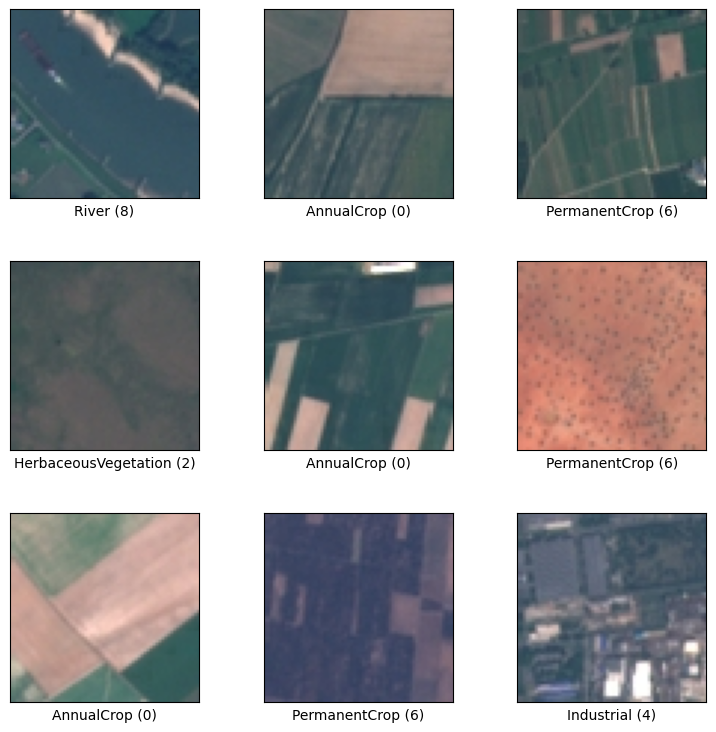

In [65]:
fig = tfds.show_examples(all_dataset, ds_info)